In [1]:
from emle.models import EMLE, ANI2xEMLE, MACEEMLE
from emle_bespoke.patching import EMLEPatched
from emle_bespoke._constants import HARTREE_TO_KJ_MOL
import pickle as pkl
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score
from math import sqrt
import time as time

/home/joaomorado/opt/micromamba/envs/emle-bespoke/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indi

In [2]:
pre_paths = {
    "iter_1": "/home/joaomorado/mnsol_sampling/run_fixed/ml_mm_mechanical_iter_1/merged/merged_ref_data_iter_1.pkl",
    "iter_2": "/home/joaomorado/mnsol_sampling/run_fixed/ml_mm_mechanical_iter_1/merged/merged_ref_data_iter_2.pkl",
    "iter_3": "/home/joaomorado/mnsol_sampling/run_fixed/ml_mm_mechanical_iter_1/merged/merged_ref_data_iter_3.pkl",   
}

models = {
    "general": None,
    "bespoke_iter_1": "/home/joaomorado/mnsol_sampling/run_fixed/ml_mm_mechanical_iter_1/training/ligand_bespoke.mat",
    "bespoke_iter_2": "/home/joaomorado/mnsol_sampling/run_fixed/ml_mm_mechanical_iter_1/training2/ligand_bespoke.mat",
    "patched_iter_1_species": "/home/joaomorado/mnsol_sampling/run_fixed/ml_mm_mechanical_iter_1/training/ligand_bespoke_patched_species.mat",
    "patched_iter_1_reference": "/home/joaomorado/mnsol_sampling/run_fixed/ml_mm_mechanical_iter_1/training/ligand_bespoke_patched_reference.mat",
    "patched_iter_2_species": "/home/joaomorado/mnsol_sampling/run_fixed/ml_mm_mechanical_iter_1/training2/ligand_bespoke_patched_species.mat",
    "patched_iter_2_reference": "/home/joaomorado/mnsol_sampling/run_fixed/ml_mm_mechanical_iter_1/training2/ligand_bespoke_patched_reference.mat",
}

In [3]:
import pandas as pd
import time
import torch
import pickle as pkl
import numpy as np
from math import sqrt

# Initialize an empty list to store results (RMSE, MSE, R², and MAE)
results = []

label = "Total Interaction Energy"

for model_key, model_value in models.items():
    for alpha_mode in ["species", "reference"]:
        for pre_key, pre_value in pre_paths.items():

            if "species" in model_key and alpha_mode == "reference":
                continue
            if "reference" in model_key and alpha_mode == "species":
                continue
            # Load the reference data
            mol = "water"
            with open(pre_value, "rb") as f:
                data = pkl.load(f)

            # Bespoke model
            use_bespoke = True if "general_model" not in model_key else False
            bespoke_model = model_value if use_bespoke else None
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            dtype = torch.float64
            alpha_static = 1.0
            beta_induced = 1.0

            emle_model = EMLEPatched(
                device=device,
                dtype=dtype,
                model=bespoke_model,
                alpha_static=alpha_static,
                beta_induced=beta_induced,
                method="electrostatic",
                alpha_mode=alpha_mode
            )

            from emle.train._utils import pad_to_max

            # Pad data to max length
            z = pad_to_max(data["z"]).to(device=device, dtype=torch.int64)
            charges_mm = pad_to_max(data["charges_mm"]).to(device=device, dtype=dtype)
            xyz_qm = pad_to_max(data["xyz_qm"]).to(device=device, dtype=dtype)
            xyz_mm = pad_to_max(data["xyz_mm"]).to(device=device, dtype=dtype)

            # Constants
            HARTREE_TO_KJ_MOL = 2625.5  # Example conversion factor

            # Define batch parameters
            n_batches = 32
            n_samples = z.shape[0]
            batch_size = n_samples // n_batches

            # Initialize storage for results
            e_static_all = []
            e_ind_all = []

            # Timer start
            time0 = time.time()

            # Batch processing
            for i in range(n_batches):
                batch_start = i * batch_size
                batch_end = (i + 1) * batch_size if i < n_batches - 1 else n_samples  # Handle last batch
                print(f"Processing batch {i+1}/{n_batches} with {batch_end - batch_start} samples")
                
                # Forward pass for current batch
                e_static_emle, e_ind_emle = emle_model.forward(
                    z[batch_start:batch_end],
                    charges_mm[batch_start:batch_end],
                    xyz_qm[batch_start:batch_end],
                    xyz_mm[batch_start:batch_end],
                )

                # Convert units
                e_static_emle = e_static_emle * HARTREE_TO_KJ_MOL
                e_ind_emle = e_ind_emle * HARTREE_TO_KJ_MOL

                # Collect results
                e_static_all.append(e_static_emle.detach().cpu())
                e_ind_all.append(e_ind_emle.detach().cpu())

            # Concatenate results into single tensors
            e_static_emle = torch.cat(e_static_all, dim=0)
            e_ind_emle = torch.cat(e_ind_all, dim=0)

            # Example data (replace with your actual data)
            e_static = np.array([x.item() for x in data["e_static"]])
            e_ind = np.array([x.item() for x in data["e_ind"]])

            # Timer end
            print("Time taken for batched forward pass: ", time.time() - time0)

            # Calculate RMSE
            # convert to numpy
            if label == "Total Interaction Energy":
                e_total_emle = e_static_emle + e_ind_emle
                e_total_ref = e_static + e_ind
            elif label == "Static Interaction Energy":
                e_total_emle = e_static_emle
                e_total_ref = e_static
            elif label == "Induced Interaction Energy":
                e_total_emle = e_ind_emle
                e_total_ref = e_ind
            else:
                raise ValueError("Invalid label")

            # convert to numpy
            e_total_emle = e_total_emle.cpu().numpy()
            e_total_ref = e_total_ref
            def compute_metrics(true_values, predicted_values):
                mse = np.mean(predicted_values - true_values)
                rmse = sqrt(np.mean((predicted_values - true_values) ** 2))
                mae = np.mean(np.abs(predicted_values - true_values))
                r2 = r2_score(true_values, predicted_values)
                return rmse, mse, r2, mae

            rmse, mse, r2, mae = compute_metrics(e_total_ref, e_total_emle)
         
            # Calculate R² (R-squared)
            ss_res = np.sum((e_total_ref - e_total_emle) ** 2)
            ss_tot = np.sum((e_total_ref - np.mean(e_total_ref)) ** 2)
            r2 = 1 - (ss_res / ss_tot)

            # Append results for this iteration
            results.append({
                "pre_path": pre_key,
                "model": model_key,
                "alpha_mode": alpha_mode,
                "rmse": rmse,
                "mse": mse,
                "mae": mae,
                "r2": r2
            })

# Convert the results into a Pandas DataFrame
df = pd.DataFrame(results)

# Save the DataFrame to a CSV file
df.to_csv("model_performance_results.csv", index=False)

print("Results saved to model_performance_results.csv")


Processing batch 1/32 with 62 samples
Processing batch 2/32 with 62 samples
Processing batch 3/32 with 62 samples
Processing batch 4/32 with 62 samples
Processing batch 5/32 with 62 samples
Processing batch 6/32 with 62 samples
Processing batch 7/32 with 62 samples
Processing batch 8/32 with 62 samples
Processing batch 9/32 with 62 samples
Processing batch 10/32 with 62 samples
Processing batch 11/32 with 62 samples
Processing batch 12/32 with 62 samples
Processing batch 13/32 with 62 samples
Processing batch 14/32 with 62 samples
Processing batch 15/32 with 62 samples
Processing batch 16/32 with 62 samples
Processing batch 17/32 with 62 samples
Processing batch 18/32 with 62 samples
Processing batch 19/32 with 62 samples
Processing batch 20/32 with 62 samples
Processing batch 21/32 with 62 samples
Processing batch 22/32 with 62 samples
Processing batch 23/32 with 62 samples
Processing batch 24/32 with 62 samples
Processing batch 25/32 with 62 samples
Processing batch 26/32 with 62 sam

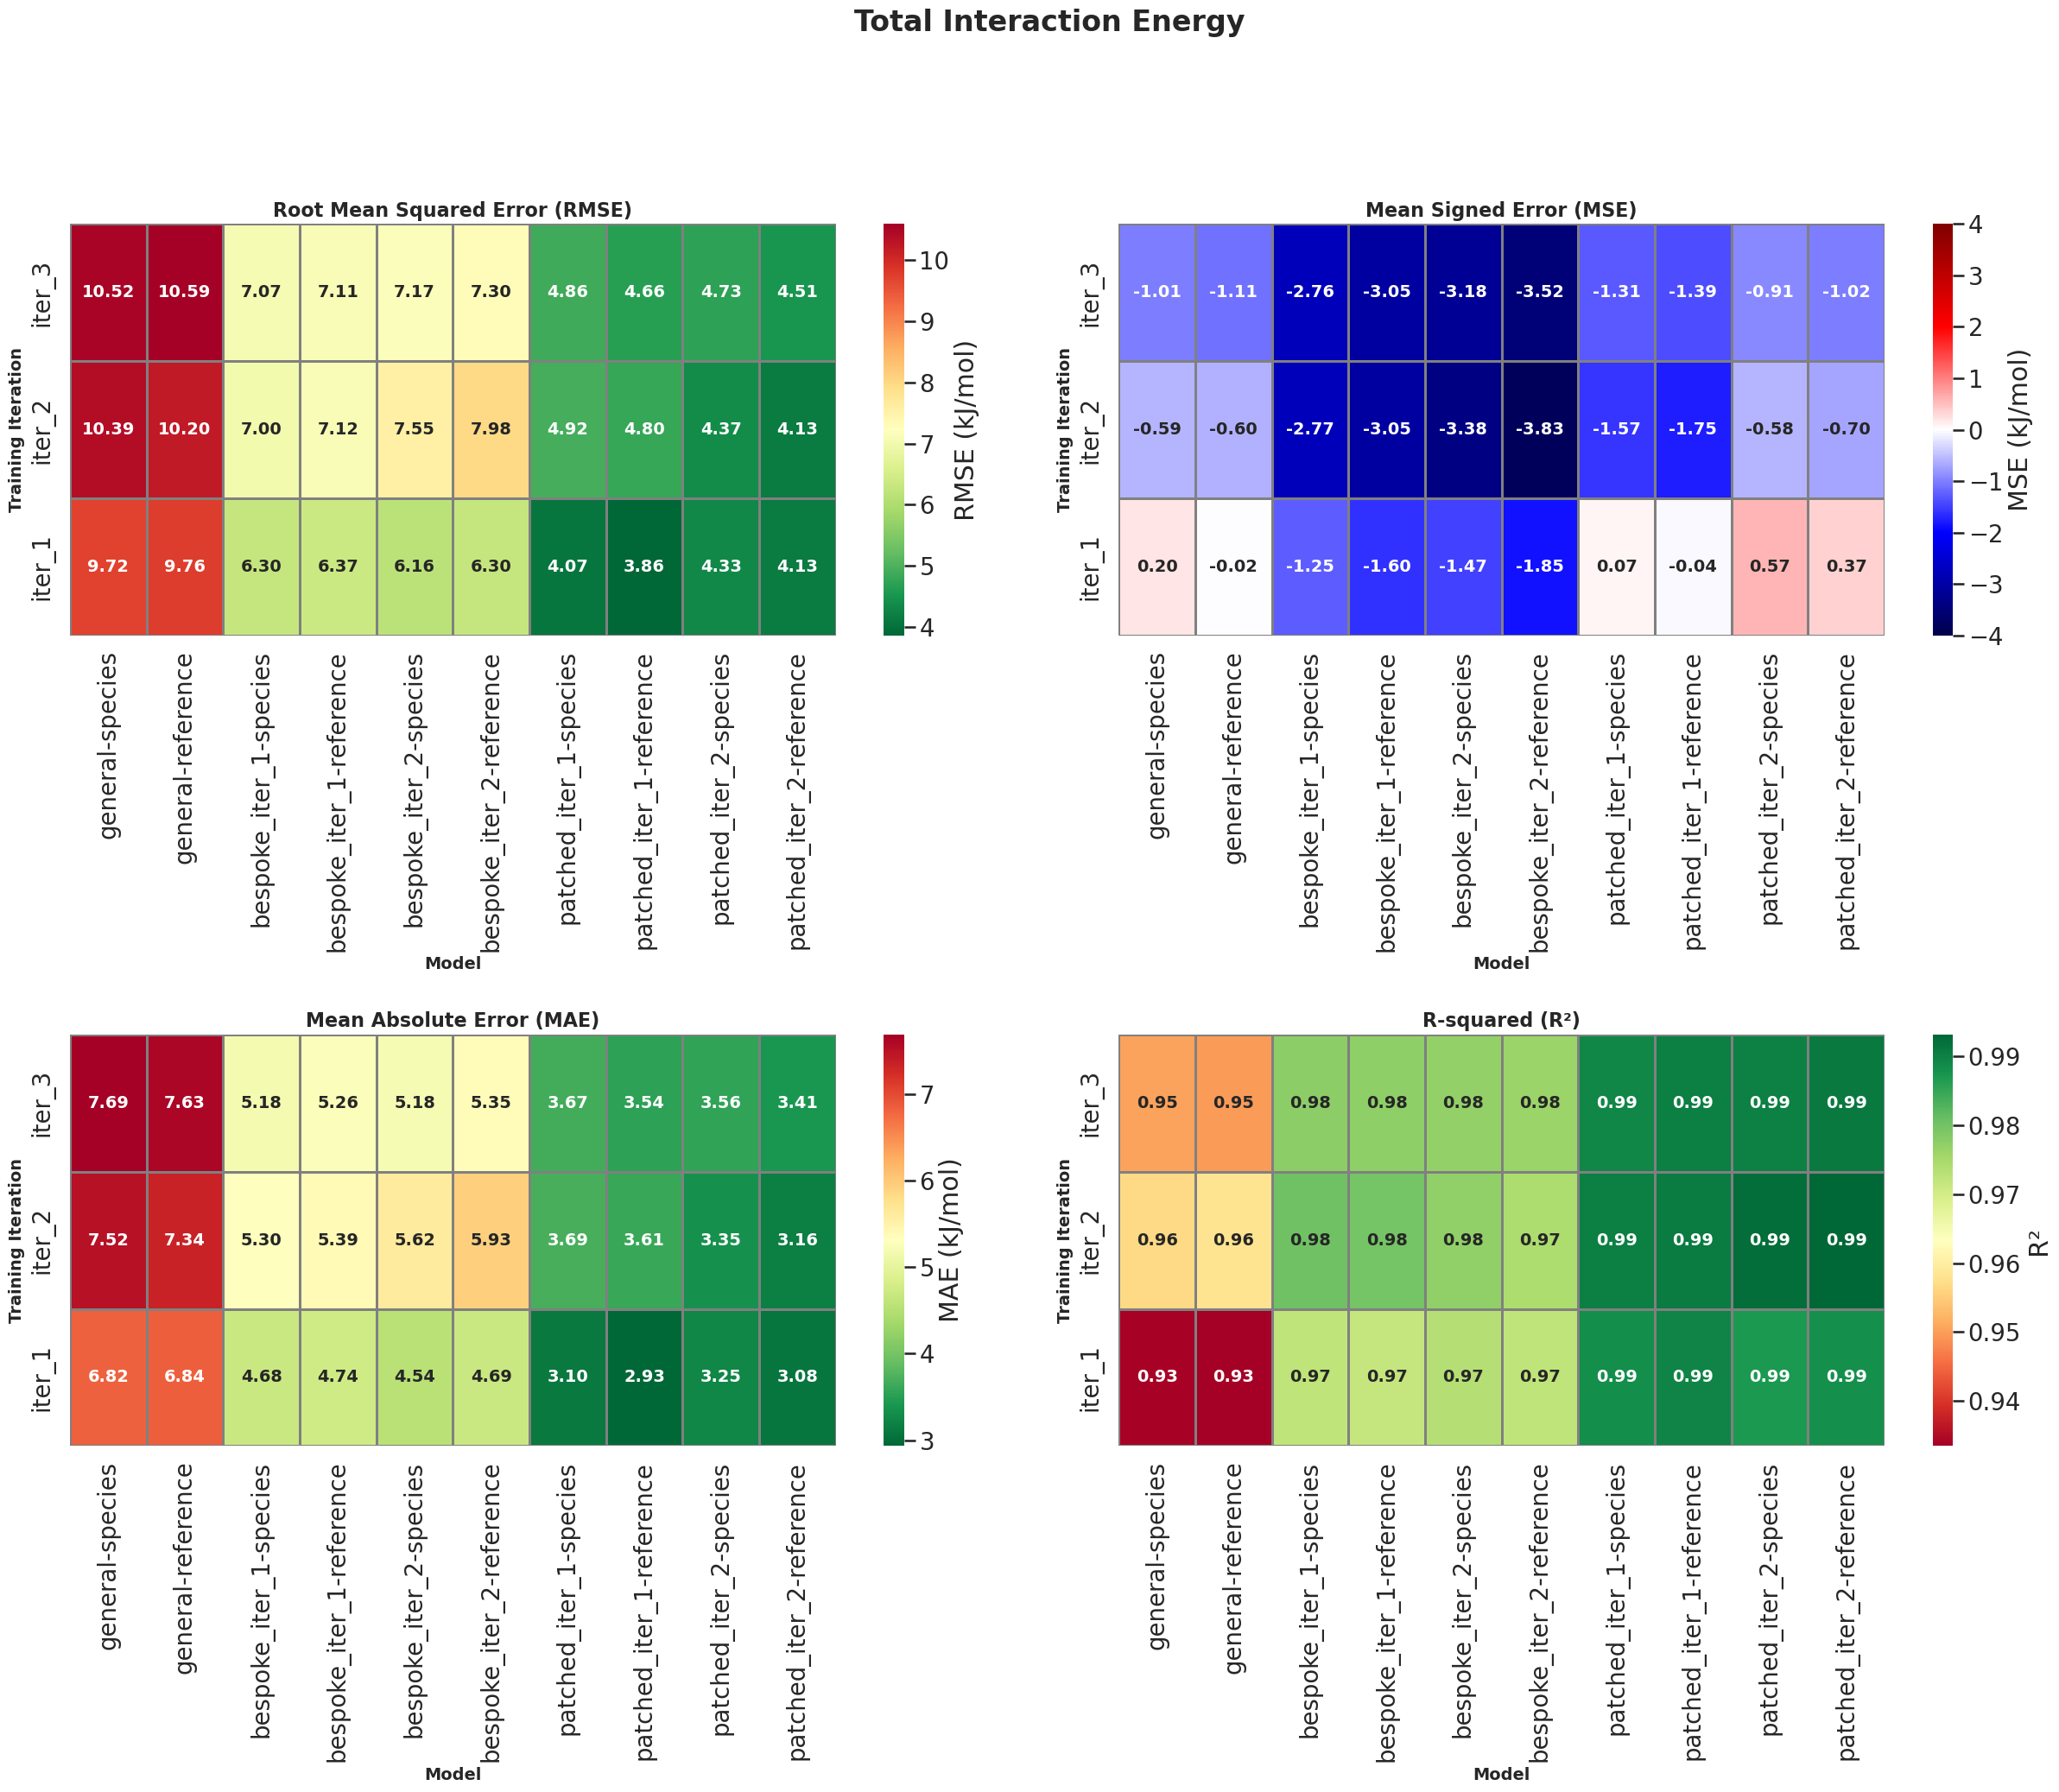

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'results' is the list containing your collected data
df = pd.DataFrame(results)

# Clean up the 'model' column by removing '_reference' and '_species'
df["model"] = df["model"].str.replace("_reference", "").str.replace("_species", "")

# Pivot the DataFrame for different error metrics (RMSE, MSE, MAE, R2)
pivot_rmse = df.pivot(index="pre_path", columns=["model", "alpha_mode"], values="rmse")
pivot_mse = df.pivot(index="pre_path", columns=["model", "alpha_mode"], values="mse")
pivot_mae = df.pivot(index="pre_path", columns=["model", "alpha_mode"], values="mae")
pivot_r2 = df.pivot(index="pre_path", columns=["model", "alpha_mode"], values="r2")

# Set a style for the plots
sns.set_context("talk", font_scale=1.2)  # Set font size for readability
sns.set_style("whitegrid")  # White grid background for clarity

# Set the figure size to be more proportional
plt.figure(figsize=(25, 20))  # Adjusted figure size (more compact)

# Title figure
plt.suptitle(f"{label}", fontsize=24, weight="bold", y=1.05)  # Adjusted title size and position

# Plot 1: RMSE Heatmap
plt.subplot(2, 2, 1)
sns.heatmap(
    pivot_rmse.iloc[::-1],  # Reverse the order for better visual presentation
    annot=True,
    cmap="RdYlGn_r",  # Green-to-Red color map (reversed)
    fmt=".2f",  # Formatting the numbers
    linewidths=0.8,  # Thicker grid lines
    linecolor='gray',  # Grid lines color
    cbar_kws={"label": "RMSE (kJ/mol)"},  # Color bar label
    annot_kws={"size": 14, "weight": "bold"},  # Annotation formatting
    cbar=True  # Include color bar
)
plt.title("Root Mean Squared Error (RMSE)", fontsize=16, weight="bold")
plt.xlabel("Model", fontsize=14, weight="bold")
plt.ylabel("Training Iteration", fontsize=14, weight="bold")

# Plot 2: MSE Heatmap
vmin = np.floor(pivot_mse.min().min())
vmax = np.ceil(pivot_mse.max().max())

max_val = max(abs(vmin), abs(vmax))
vmin = -max_val
vmax = max_val

plt.subplot(2, 2, 2)
sns.heatmap(
    pivot_mse.iloc[::-1],  # Reverse the order for better visual presentation
    annot=True,
    cmap="seismic",  # Balanced color map for MSE
    fmt=".2f",  # Formatting the numbers
    linewidths=0.8,  # Thicker grid lines
    linecolor='gray',  # Grid lines color
    cbar_kws={"label": "MSE (kJ/mol)"},  # Color bar label
    annot_kws={"size": 14, "weight": "bold"},  # Annotation formatting
    cbar=True,
    vmin=vmin,
    vmax=vmax
)
plt.title("Mean Signed Error (MSE)", fontsize=16, weight="bold")
plt.xlabel("Model", fontsize=14, weight="bold")
plt.ylabel("Training Iteration", fontsize=14, weight="bold")

# Plot 3: MAE Heatmap
plt.subplot(2, 2, 3)
sns.heatmap(
    pivot_mae.iloc[::-1],  # Reverse the order for better visual presentation
    annot=True,
    cmap="RdYlGn_r",  # Yellow-to-Brown color map for MAE
    fmt=".2f",  # Formatting the numbers
    linewidths=0.8,  # Thicker grid lines
    linecolor='gray',  # Grid lines color
    cbar_kws={"label": "MAE (kJ/mol)"},  # Color bar label
    annot_kws={"size": 14, "weight": "bold"},  # Annotation formatting
    cbar=True,
)
plt.title("Mean Absolute Error (MAE)", fontsize=16, weight="bold")
plt.xlabel("Model", fontsize=14, weight="bold")
plt.ylabel("Training Iteration", fontsize=14, weight="bold")

# Plot 4: R² Heatmap
plt.subplot(2, 2, 4)
sns.heatmap(
    pivot_r2.iloc[::-1],  # Reverse the order for better visual presentation
    annot=True,
    cmap="RdYlGn",  # Balanced color map for R²
    fmt=".2f",  # Formatting the numbers
    linewidths=0.8,  # Thicker grid lines
    linecolor='gray',  # Grid lines color
    cbar_kws={"label": "R²"},  # Color bar label
    annot_kws={"size": 14, "weight": "bold"},  # Annotation formatting
    cbar=True
)
plt.title("R-squared (R²)", fontsize=16, weight="bold")
plt.xlabel("Model", fontsize=14, weight="bold")
plt.ylabel("Training Iteration", fontsize=14, weight="bold")

# Adjust spacing between the subplots to prevent overlap
plt.tight_layout(pad=1.5)  # Adjusted padding between subplots

# Show the plot
plt.show()
